# Exploratory Data Analysis: IBM AML HI-Small Dataset

**Project**: Explainable Anomaly Detection in Dynamic Financial Networks  
**Dataset**: IBM Transactions for Anti-Money Laundering (HI-Small)  
**Objective**: Understand data characteristics to inform Graph ML model development


## 1. Setup

In [1]:
import sys
sys.path.append('../src')

import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from data_loader import *
from graph_builder import *
from feature_engineering import *
from pattern_analyzer import *
from visualization import *
from visualization import *

set_publication_style()
%matplotlib inline

## 2. Data Loading & Overview

In [2]:
#run if you dont have the data downloaded this is a few gb of data
import kagglehub
path = kagglehub.dataset_download("ealtman2019/ibm-transactions-for-anti-money-laundering-aml")
print("Path to dataset files:", path)

Path to dataset files: /home/linchieh/.cache/kagglehub/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml/versions/8


In [3]:
dataset_name = "HI-Small"

print(f"Loading {dataset_name}...\n")
trans_df = load_transactions(dataset_size=dataset_name)
accounts_df = load_accounts(dataset_size=dataset_name)
patterns_df = load_patterns(dataset_size=dataset_name)

Loading HI-Small...


Loading transactions from: /home/linchieh/.cache/kagglehub/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml/versions/8/HI-Small_Trans.csv
File size: 453.6 MB

Loaded 5,078,345 transactions
Date range: 2022-09-01 00:00:00 to 2022-09-18 16:18:00
Laundering transactions: 5,177 (0.102%)

Loading accounts from: /home/linchieh/.cache/kagglehub/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml/versions/8/HI-Small_accounts.csv

Loaded 518,581 accounts from 30470 banks

Loading patterns from: /home/linchieh/.cache/kagglehub/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml/versions/8/HI-Small_Patterns.txt

Loaded patterns


In [4]:
summary = get_dataset_summary(trans_df)

print("="*80)
print("DATASET SUMMARY")
print("="*80)
print(f"Total Transactions: {summary['total_transactions']:,}")
print(f"Laundering Transactions: {summary['laundering_transactions']:,} ({summary['laundering_ratio']*100:.3f}%)")
print(f"Date Range: {summary['date_range']['days']} days")
print(f"Unique Accounts: {summary['unique_accounts']:,}")
print(f"Unique Banks: {summary['unique_banks']:,}")
print(f"Currencies: {', '.join(summary['currencies'])}")
print(f"Payment Formats: {', '.join(summary['payment_formats'])}")

DATASET SUMMARY
Total Transactions: 5,078,345
Laundering Transactions: 5,177 (0.102%)
Date Range: 17 days
Unique Accounts: 515,080
Unique Banks: 30,528
Currencies: US Dollar, Bitcoin, Euro, Australian Dollar, Yuan, Rupee, Mexican Peso, Yen, UK Pound, Ruble, Canadian Dollar, Swiss Franc, Brazil Real, Saudi Riyal, Shekel
Payment Formats: Reinvestment, Cheque, Credit Card, ACH, Cash, Wire, Bitcoin


## 3. Transaction-Level Analysis

### 3.1 Temporal Patterns

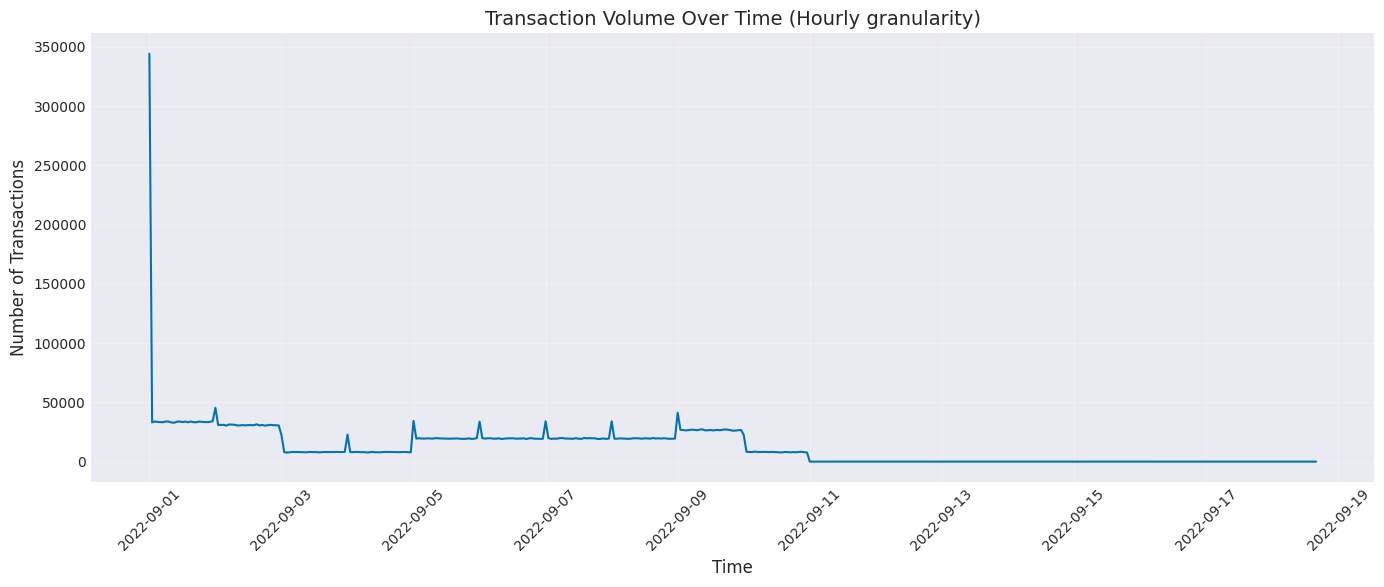

In [5]:
fig = plot_transaction_volume_over_time(trans_df)
plt.show()

#### Observations: 
- Front-loaded distribution with crazy amounts of transactions on day 1, some transactions from days 2 to 10 and nothing afterwards. This is artifact of data synthesis process. Focus analysis on intraday patterns.

#### Architectural/Feature Engineering Implications:
- T-GVAE is likely not going to be meaningful as learning the temporal evolution will only introduce noise generated by the synthetic dataset's artifact. We pivot to static and possibly intra-day analysis, perhaps can include attention mechanisms
- There are still meaningful hourly patterns(?) 
- Prioritise structure (degree, centrality, patterns) over time

### 3.2 Amount Analysis

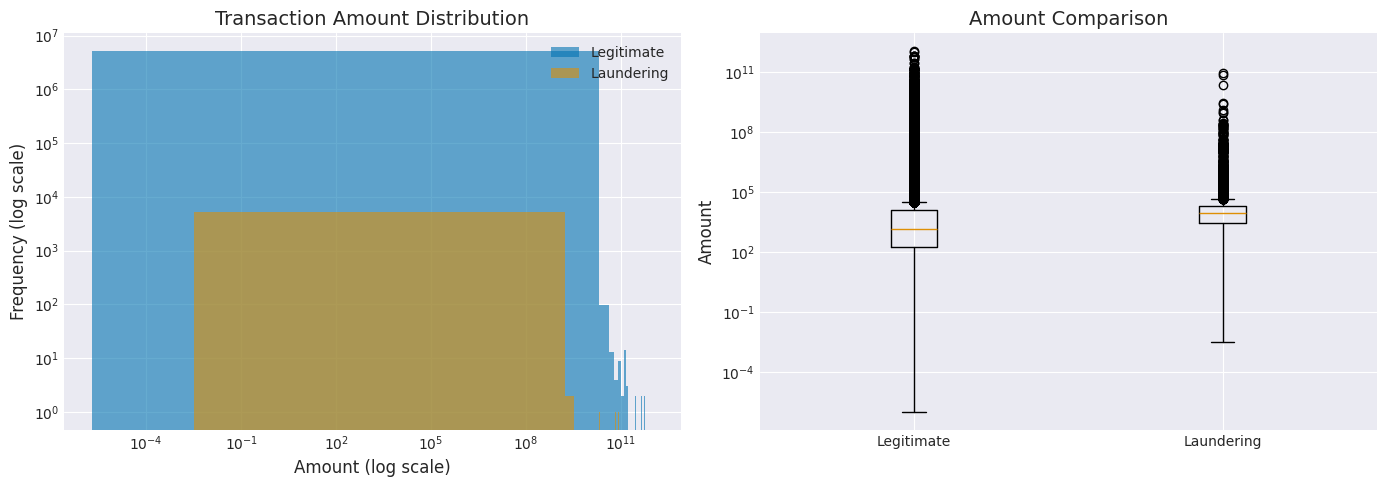

In [ ]:
fig = plot_amount_distribution(trans_df)
plt.show()

In [ ]:
# summary stats wrt above charts
legit_amounts = trans_df[trans_df['is_laundering']==0]['amount_received']
launder_amounts = trans_df[trans_df['is_laundering']==1]['amount_received']

print("Amount Statistics Comparison:")
print("\nLegitimate Transactions:")
print(legit_amounts.describe())
print("\nLaundering Transactions:")
print(launder_amounts.describe())

Amount Statistics Comparison:

Legitimate Transactions:
count    5.073168e+06
mean     5.957962e+06
std      1.036563e+09
min      1.000000e-06
25%      1.830700e+02
50%      1.407510e+03
75%      1.232251e+04
max      1.046302e+12
Name: amount_received, dtype: float64

Laundering Transactions:
count    5.177000e+03
mean     3.613531e+07
std      1.527919e+09
min      3.227000e-03
25%      2.634970e+03
50%      8.667210e+03
75%      1.883227e+04
max      8.485314e+10
Name: amount_received, dtype: float64


#### Observations:
1. Narrower Distribution: Laundering transactions show less variance in amounts (tighter clustering in histogram)
2. Higher Mean: Average laundering amount (~36M) significantly exceeds legitimate (~6M) 

#### Feature Engineering Implications:
- Amount percentile within account history is discriminative
- Statistical dispersion metrics (std, IQR, coefficient of variation) useful for account profiling
- Z-scores and anomaly scores based on amount can flag suspicious transactions

#### Recommended Features:
- Transaction amount Z-score relative to account baseline
- Coefficient of variation for account transaction amounts  
- Entropy of amount distribution per account
- Distance from typical legitimate amount distribution

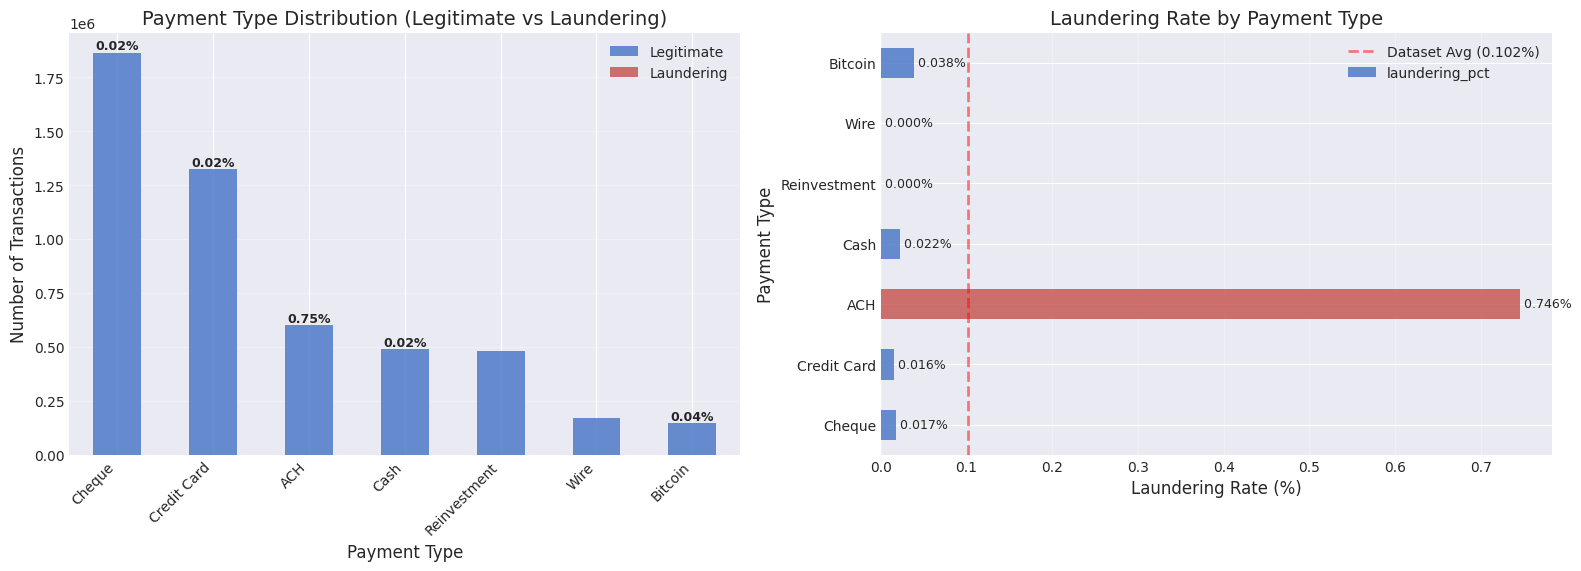


Payment Type Analysis Summary:
Overall Dataset Laundering Rate: 0.102%

                Legitimate  Laundering    total  laundering_pct
payment_format                                                 
Cheque             1864007         324  1864331        0.017379
Credit Card        1323118         206  1323324        0.015567
ACH                 596314        4483   600797        0.746175
Cash                490783         108   490891        0.022001
Reinvestment        481056           0   481056        0.000000
Wire                171855           0   171855        0.000000
Bitcoin             146035          56   146091        0.038332


In [ ]:
fig = plot_payment_type_breakdown(trans_df)
plt.show()

payment_breakdown = trans_df.groupby(['payment_format', 'is_laundering']).size().unstack(fill_value=0)
payment_breakdown.columns = ['Legitimate', 'Laundering']
payment_breakdown['total'] = payment_breakdown.sum(axis=1)
payment_breakdown['laundering_pct'] = (payment_breakdown['Laundering'] / payment_breakdown['total'] * 100)
payment_breakdown = payment_breakdown.sort_values('total', ascending=False)

print("\nPayment Type Analysis Summary:")
print("="*80)
overall_rate = trans_df['is_laundering'].sum() / len(trans_df) * 100
print(f"Overall Dataset Laundering Rate: {overall_rate:.3f}%\n")
print(payment_breakdown[['Legitimate', 'Laundering', 'total', 'laundering_pct']].to_string())
print("="*80)

#### Observations:
- ACH is High-Risk: 0.746% laundering rate 7.3× higher than dataset average (0.102%)
- ACH Concentration: Contains 87% of all laundering transactions (4,483/5,177) despite being only 12% of total volume
- Low-Risk Types: Cheque (0.017%) and Credit Card (0.016%) are safer than average

#### Feature Engineering Implications:
- `payment_format` is a highly discriminative categorical feature
- Consider one-hot encoding with risk weighting
- ACH transactions deserve elevated scrutiny in detection models
- May warrant payment-type-specific thresholds in rule-based systems

## 4. Account-Level Analysis

### 4.1 Account Statistics

In [ ]:
account_stats = compute_account_statistics(trans_df)

Computing account statistics...
  Computed statistics for 515,080 accounts


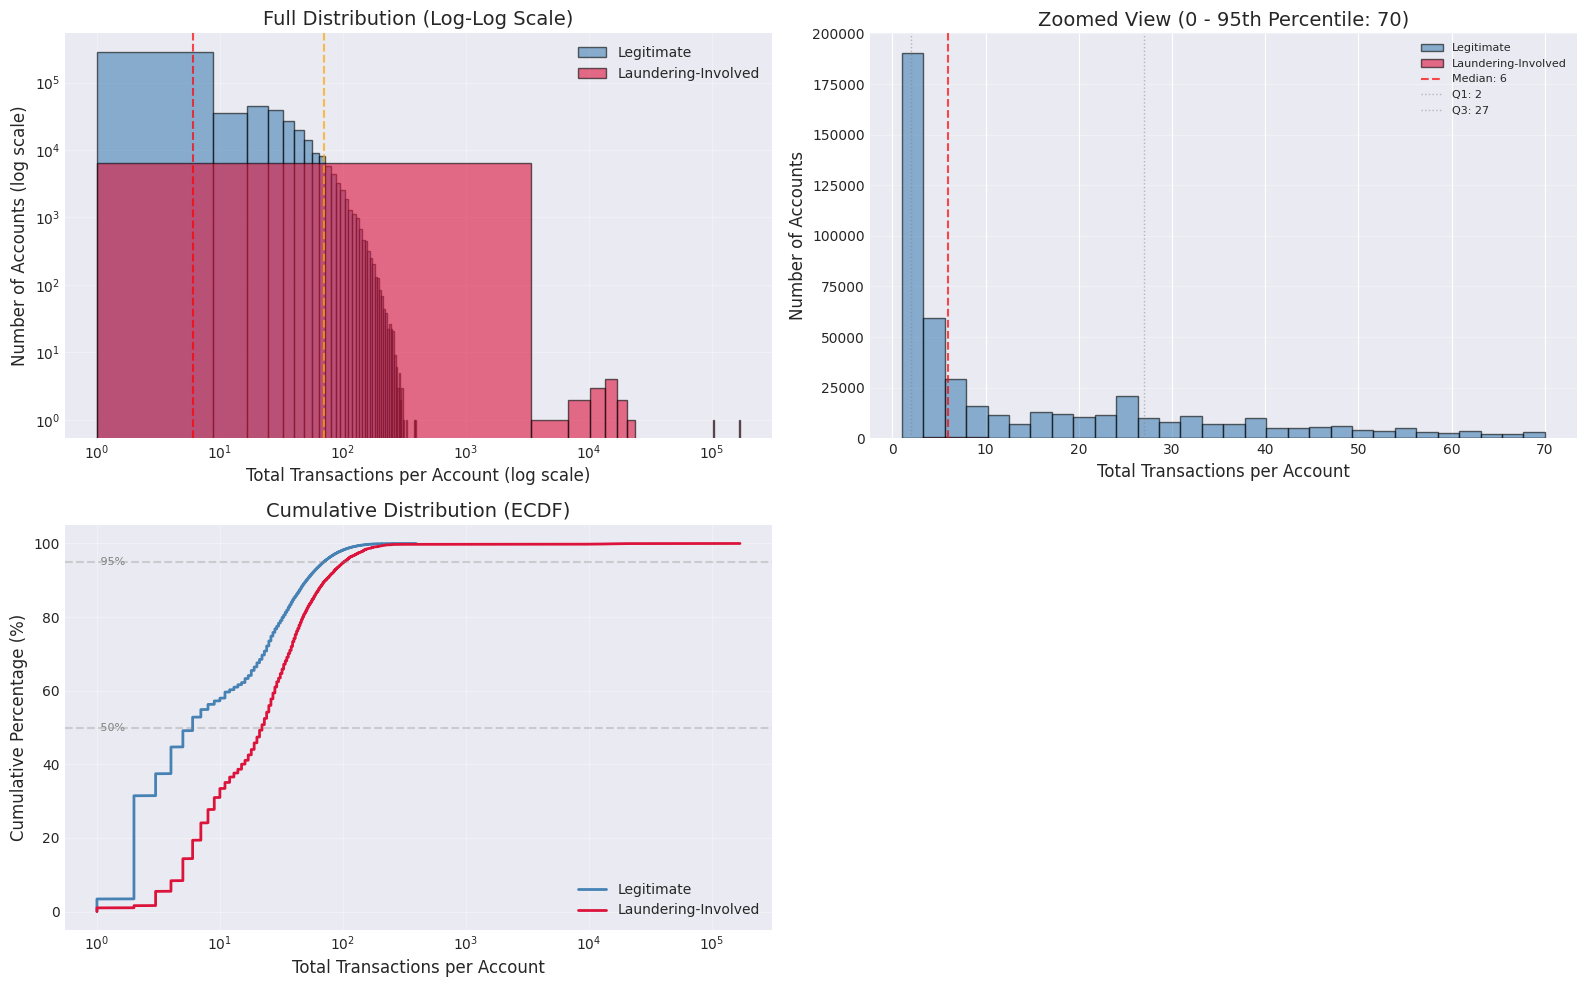

In [ ]:
fig = plot_transaction_frequency_per_account(account_stats)
plt.show()

In [ ]:
print("\n" + "="*80)
print("ACCOUNT ACTIVITY TIER ANALYSIS")
print("="*80)
tier_stats = compute_account_activity_statistics(account_stats)
display(tier_stats)


ACCOUNT ACTIVITY TIER ANALYSIS


,tier,tx_range,num_accounts,pct_of_total,median_tx,laundering_accounts,laundering_rate_pct
0,P0-P25,1 - 2,17470,3.391706,1.0,64,0.366342
1,P25-P50,2 - 6,233418,45.316844,2.0,849,0.363725
2,P50-P75,6 - 27,133408,25.900443,15.0,2759,2.068092
3,P75-P90,27 - 51,78320,15.205405,36.0,1525,1.947140
4,P90-P95,51 - 70,25864,5.021356,58.0,487,1.882926
5,P95-P99,70 - 119,21323,4.139745,84.0,449,2.105707
6,P99-P99.9,119 - 191,4761,0.924322,137.0,168,3.528670
7,P99.9-P100,191 - 169756,516,0.100179,212.0,56,10.852713


#### Observations:

- **Median activity**: 6 transactions over 17 days (~0.35 tx/day)
- **95th percentile**: 70 transactions (~4 tx/day)  
- **Top 1%**: 100+ transactions (hubs/processors), represented by P99~
- **Interpretation**: Typical **hub-and-spoke** structure where most accounts are peripheral, few are central
- **Laundering curve is right-shifted**: Both full distribution and cumulative distribution show that laundering behavior is statistically skewed towards hub accounts

#### Feature Engineering Implications:
- Transaction count is non-linear -> Use log transformation or percentile-based features
- Activity tier classification (dormant/active/hub) as categorical feature is meaningful
- Deviation from tier baseline more informative than raw count
- Velocity metrics (transactions per day) capture intensity

#### GNN Design Considerations:

**Degree normalization required:** 
- GraphSAGE-style aggregation to prevent hub dominance (Hub accounts recieve ~10000 messages at every layer of GNN, which greatly dilutes the information coming from each neighbor node. Individual neighbor influence is microscopic. Normal accounts recieve maybe ~3 messages at every layer. Individual neighbor influence is large. With GraphSAGE, hubs with 10000 neighbors sample 25 messages from neighbors to update self, normal accounts with 3 neighbors continue to use all 3 messages from neighbors. From testing, continue to tune the sampling window. Sampling strategy that could be adopted include random sampling, and pagerank may work too)

**Hub accounts will dominate message passing in vanilla GCN:** 

- Need normalized aggregation. At every layer of the network, hub nodes (accounts) with high degree will broadcast their message to all their neighbors, which is a large number (maybe 100000). In contrast smaller accounts will only have their message sent to a small number of neighbors due to low degree (maybe 3). As a result the hub's embedding gets amplified across the network, as these directly connected nodes to the hub will further propagate the hub's embeddings to all their neighbors in the next step. This is another aspect of the problem of the previous subsection. This may lead to network homogenization as after a few layers, hubs have broadcasted their embeddings too widely and all embeddings in the graph converge towards some similar representation. This is a problem called over-smoothing.
- A solution to be used in tandem with the degree normalization solution mentioned in the previous subsection is symmetric weighting. Messages from high-degree nodes are down-weighted compared to those coming from other smaller nodes. A more sophisticated solution could also employ attention mechanisms to learn message importance.

**Mini-batch node sampling strategy during training:**

- Need importance sampling to balance hub vs peripheral nodes. For each training batch, decide which nodes to compute loss on. This balances the training dataset so hubs and peripheral nodes get equal or fairly weighted learning attention. This happens during batch construction, where random batch sampling is replaced with some other strategy. Since there are very few hub nodes (hub accounts) although they are very important graph features, there needs to be some strategy to ensure their representation during training. Stratified sampling across tiers from the Account Activity Tier Analysis table above can be used, or inverse-degree sampling where the nodes are sampled with probability inversely proportional to their degree.

**Attention mechanisms:**

- GAT may help focus on suspicious connections vs high-volume legitimate flow. Add-on to be considered if time and manpower permits

**Detection Strategy:**
- Tier-specific baselines: Different anomaly thresholds for dormant/active/hub tiers
- Cross-tier transitions: Sudden activity changes (dormant -> active) are suspicious
- Hub analysis: High-volume accounts require separate profiling (legitimate processor vs layering hub)

The tier statistics show laundering rate variations across activity levels. Accounts in the top 1-5% activity range deserve elevated scrutiny as they can process large volumes while maintaining some plausible deniability (not extreme outliers).

## 5. Graph Analysis

### 5.1 Graph Construction

**Note**: Please refer to documentation given in graph_builder.py for details on technical considerations and rationale for graph construction. There is too much and would clutter this notebook.

In [ ]:
# Build graph from sample (only first 100k transactions because networkx is quite slow sometimes)
# We sample from a contiguous timespan instead of randomly so that we don't break up fraud patterns
sample_size = 100000
print(f"Building graph from {sample_size:,} transactions...")
trans_sample = trans_df.head(sample_size)
G = build_transaction_graph(trans_sample)

Building graph from 100,000 transactions...
Building transaction graph...
  Graph built: 81,352 nodes, 100,000 edges


In [ ]:
graph_stats = calculate_graph_statistics(G)

Calculating graph statistics...
  Statistics calculated:
    num_nodes: 81,352
    num_edges: 100,000
    density: 0.0000
    avg_degree: 1.2292
    num_components: 65,217
    largest_component_size: 1,133
    largest_component_fraction: 0.0139
    avg_in_degree: 1.2292
    avg_out_degree: 1.2292


## 6. Money Laundering Pattern Analysis

### 6.1 Pattern Type Distribution

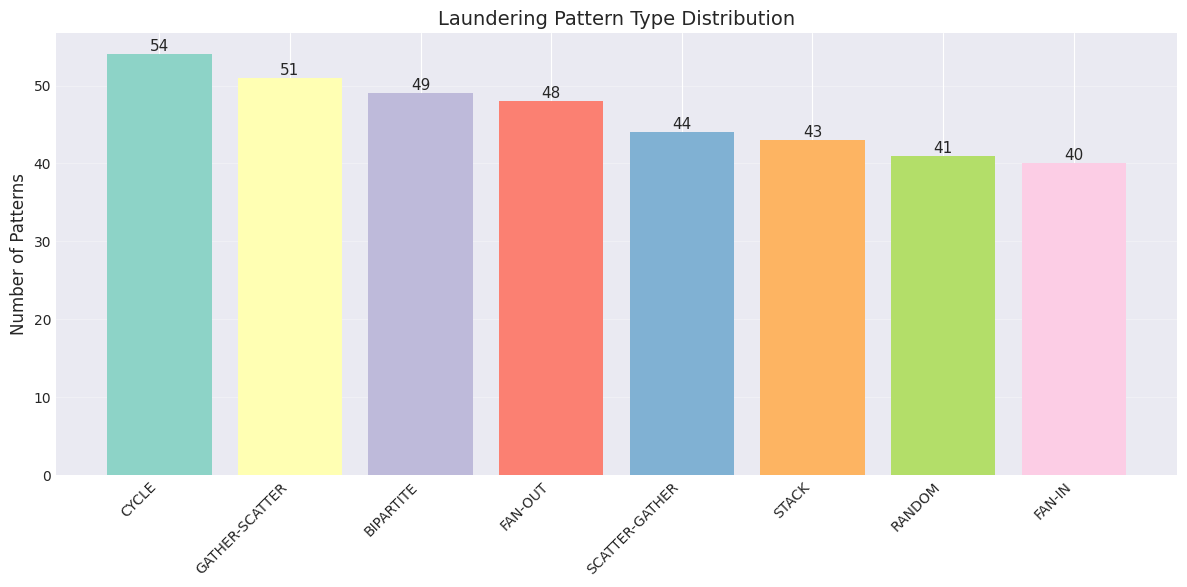

In [ ]:
fig = plot_pattern_type_distribution(patterns_df)
plt.show()

In [ ]:
pattern_stats = analyze_pattern_characteristics(patterns_df)

print("\nPattern Characteristics Summary:")
display(pattern_stats.groupby('pattern_type').agg({
    'num_accounts': ['mean', 'min', 'max'],
    'num_transactions': ['mean', 'min', 'max'],
    'total_amount': ['mean', 'sum']
}).round(2))

Analyzing pattern characteristics...
  Analyzed 370 patterns

Pattern type distribution:
pattern_type
CYCLE             54
GATHER-SCATTER    51
BIPARTITE         49
FAN-OUT           48
SCATTER-GATHER    44
STACK             43
RANDOM            41
FAN-IN            40
Name: count, dtype: int64

Pattern Characteristics Summary:


num_accounts         num_transactions         total_amount  \
                       mean min max             mean min max         mean   
pattern_type                                                                
BIPARTITE             10.73   2  30             5.37   1  15   7267566.58   
CYCLE                  5.31   2  12             5.31   2  12  18637126.69   
FAN-IN                 8.95   2  17             7.95   1  16   1978479.24   
FAN-OUT                8.12   2  17             7.12   1  16  59490733.06   
GATHER-SCATTER        14.33   2  29            14.04   2  28  23735161.30   
RANDOM                 5.66   2  12             4.66   1  11  13823166.47   
SCATTER-GATHER         8.82   2  18            14.23   2  32  34640463.95   
STACK                 15.91   2  45            10.84   2  30  26284418.63   

                              
                         sum  
pattern_type                  
BIPARTITE       3.561108e+08  
CYCLE           1.006405e+09  
FAN-IN          7.913917e+07  
FAN-OUT         2.855555e+09  
GATHER-SCATTER  1.210493e+09  
RANDOM          5.667498e+08  
SCATTER-GATHER  1.524180e+09  
STACK           1.130230e+09

#### Observations
- Class balance between each pattern type is good; we do not know if this reflects real world data, or if this is some design choice of the dataset to make model training easier
- There is significant variance of the number of accounts involved across different types of fraudulent transaction patterns
- There is significant variance in amount being transacted

### 6.2 Temporal Distribution of Patterns

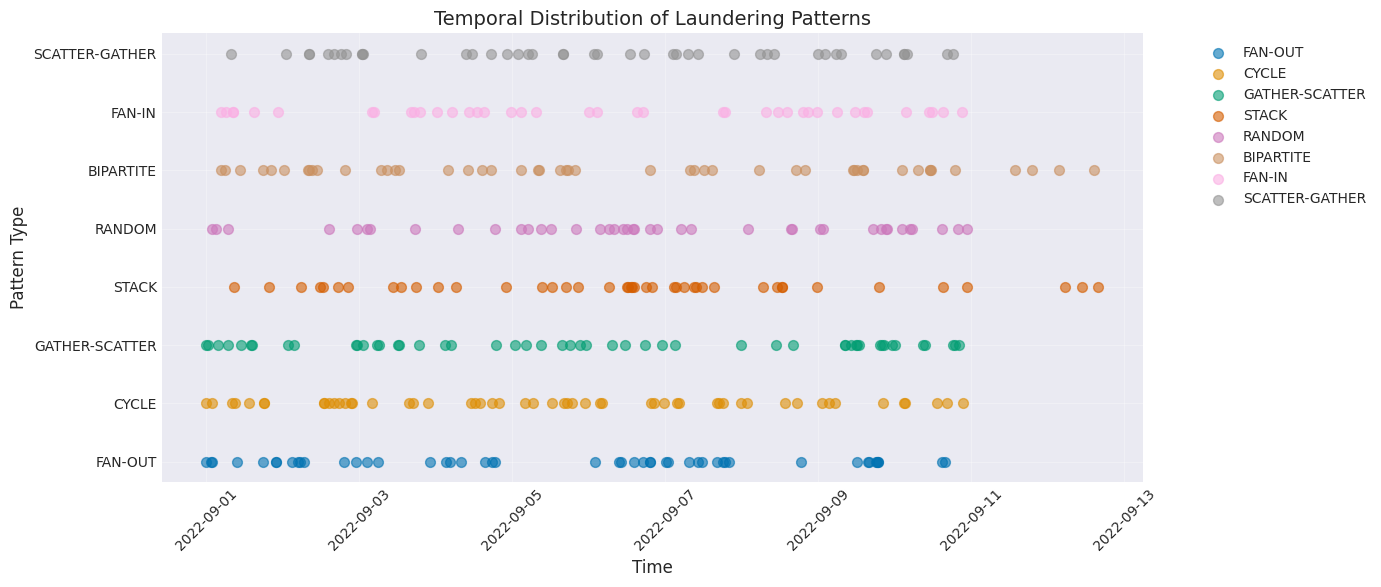

In [ ]:
fig = plot_pattern_temporal_clustering(patterns_df)
plt.show()

#### Observations
- Not sure how to interpret this data. There seem to be clear patterns in temporal clustering for the laundering patterns. However, we already know that there is an artifact in the dataset where most of the transactions happen on the first day, and dies down to a consistent lower level over the next few days. I am thus not prepared to make any conclusions based on inter-day relationships between the data, as that does not seem representative.
- However, I think it is clearer if we read this in terms of intra-day patterns, as we can cluster the transactions within the time of the day that they happen at. 

### 6.3 Pattern Structure Examples

To visualize the local graph structure of laundering patterns, we extract ego networks for sample patterns. Since our initial 100K transaction sample may not contain pattern accounts, we build a focused graph from transactions involving pattern-related accounts.

In [ ]:
pattern_accounts = set()
pattern_accounts.update(patterns_df['from_account'].values)
pattern_accounts.update(patterns_df['to_account'].values)

print(f"Total unique accounts in patterns: {len(pattern_accounts):,}")

pattern_related_trans = trans_df[
    (trans_df['from_account'].isin(pattern_accounts)) | 
    (trans_df['to_account'].isin(pattern_accounts))
]

print(f"Transactions involving pattern accounts: {len(pattern_related_trans):,}")
print(f"Building focused graph for pattern visualization...")

G_patterns = build_transaction_graph(pattern_related_trans)
pattern_graph_stats = calculate_graph_statistics(G_patterns)

Total unique accounts in patterns: 3,170
Transactions involving pattern accounts: 107,952
Building focused graph for pattern visualization...
Building transaction graph...
  Graph built: 12,842 nodes, 107,952 edges
Calculating graph statistics...
  Statistics calculated:
    num_nodes: 12,842
    num_edges: 107,952
    density: 0.0007
    avg_degree: 8.4062
    num_components: 228
    largest_component_size: 10,599
    largest_component_fraction: 0.8253
    avg_in_degree: 8.4062
    avg_out_degree: 8.4062


For how the below visualizations are generated, refer to the documentation discussing design choices involved in `pattern_analyzer.py` above methods `get_pattern_center_node` and `get_pattern_visualization_radius`

Pattern FAN-OUT (ID 1):
  Center node: 800737690
Ego network for 800737690 (radius=2): 67 nodes, 660 edges


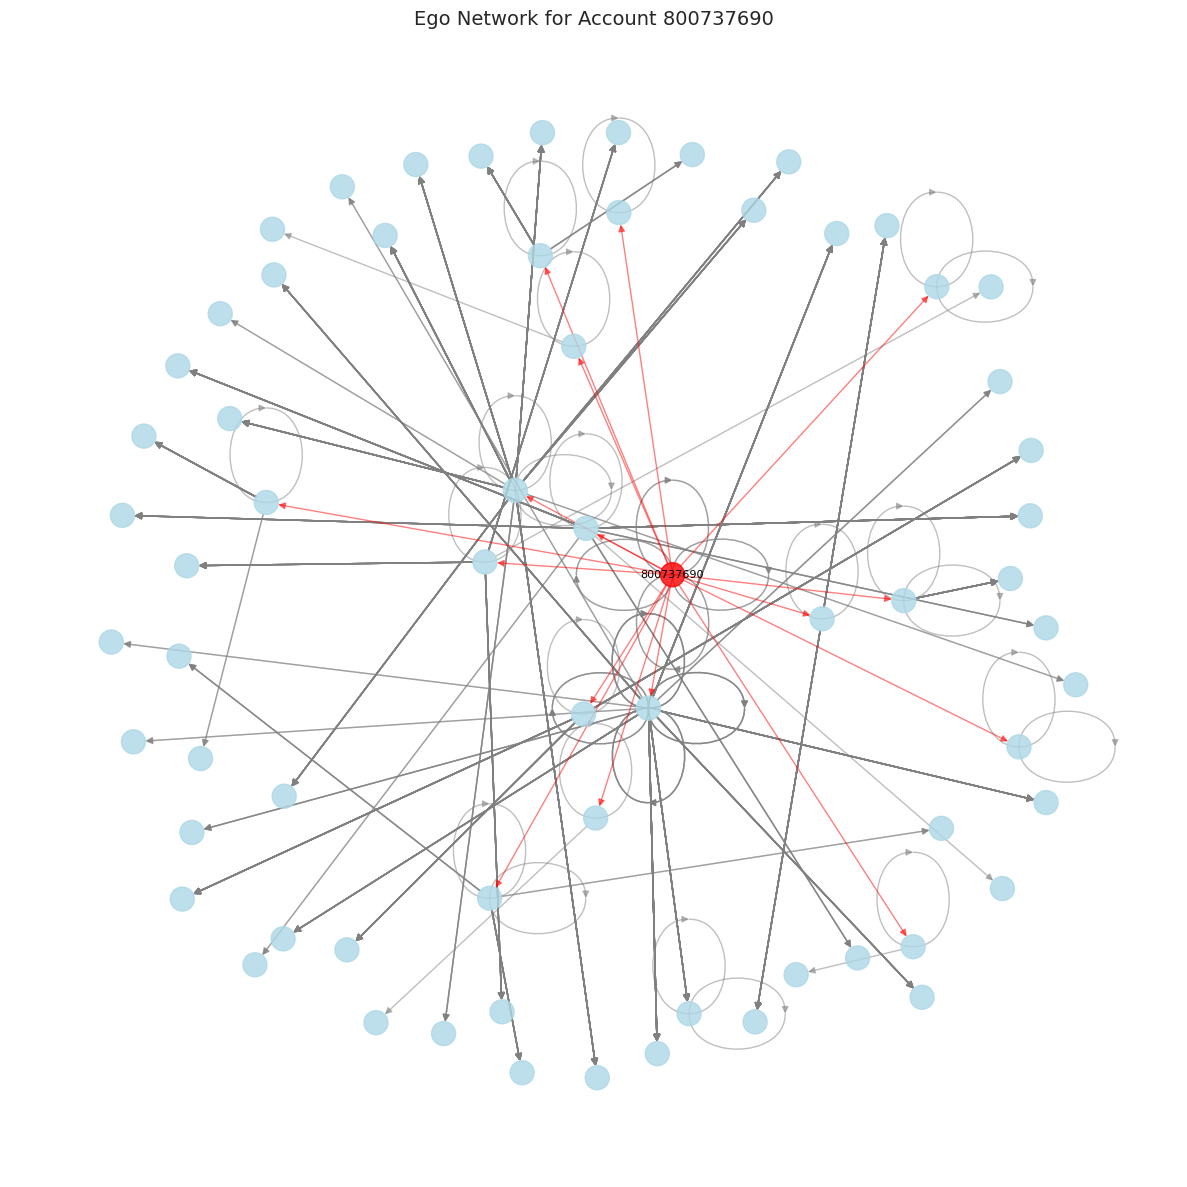

Pattern CYCLE (ID 2):
  Center node: 8013C4030
Ego network for 8013C4030 (radius=10): 24 nodes, 177 edges


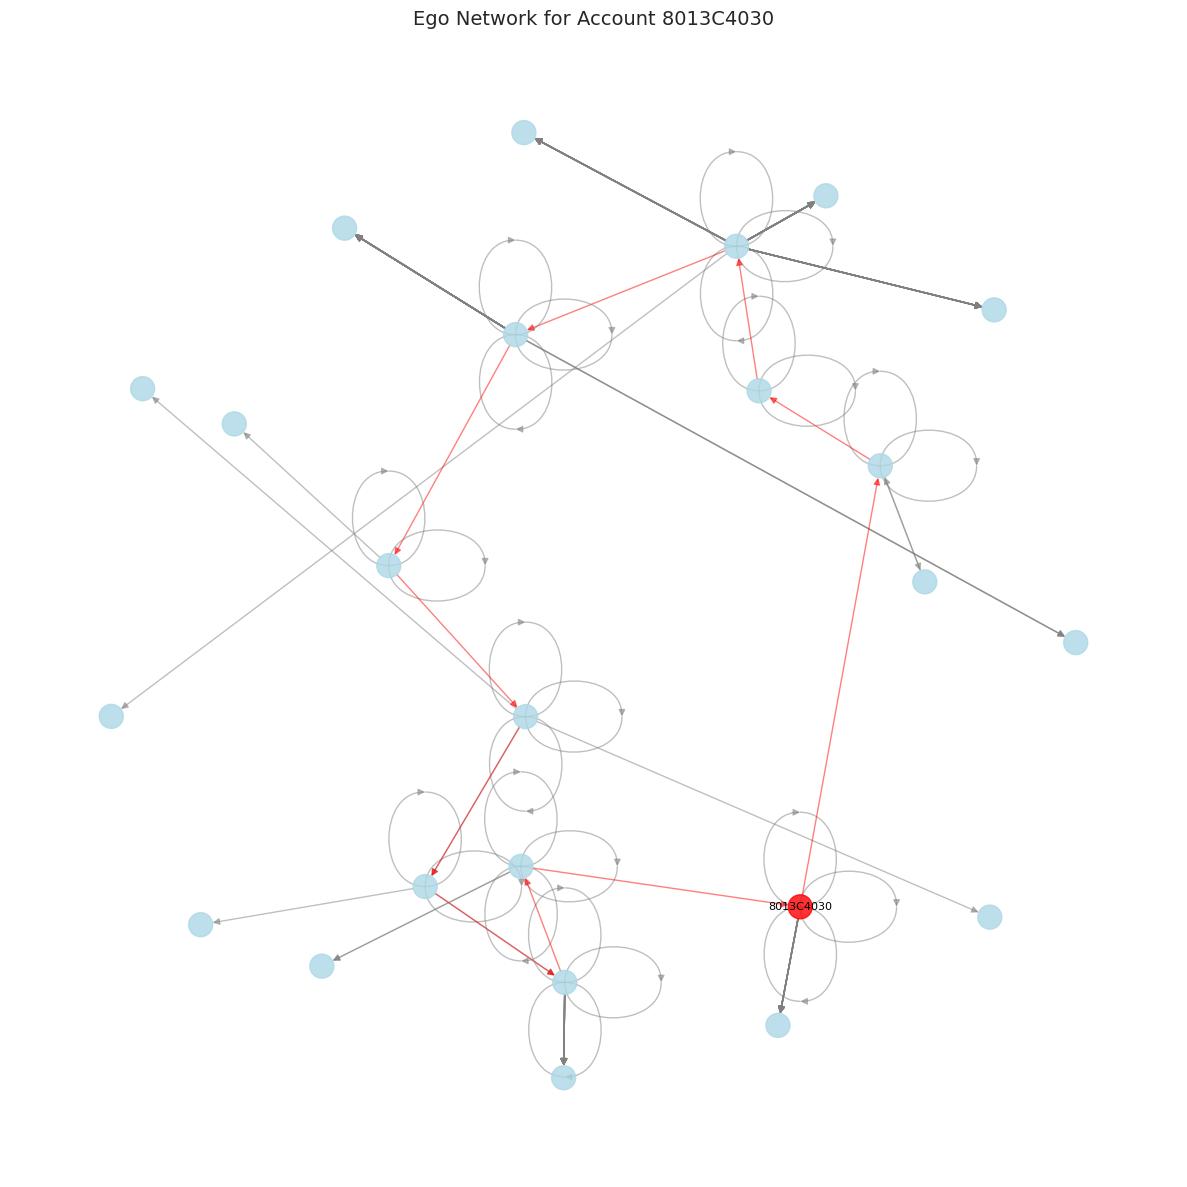

Pattern GATHER-SCATTER (ID 3):
  Center node: 811C599A0
Ego network for 811C599A0 (radius=2): 13 nodes, 176 edges


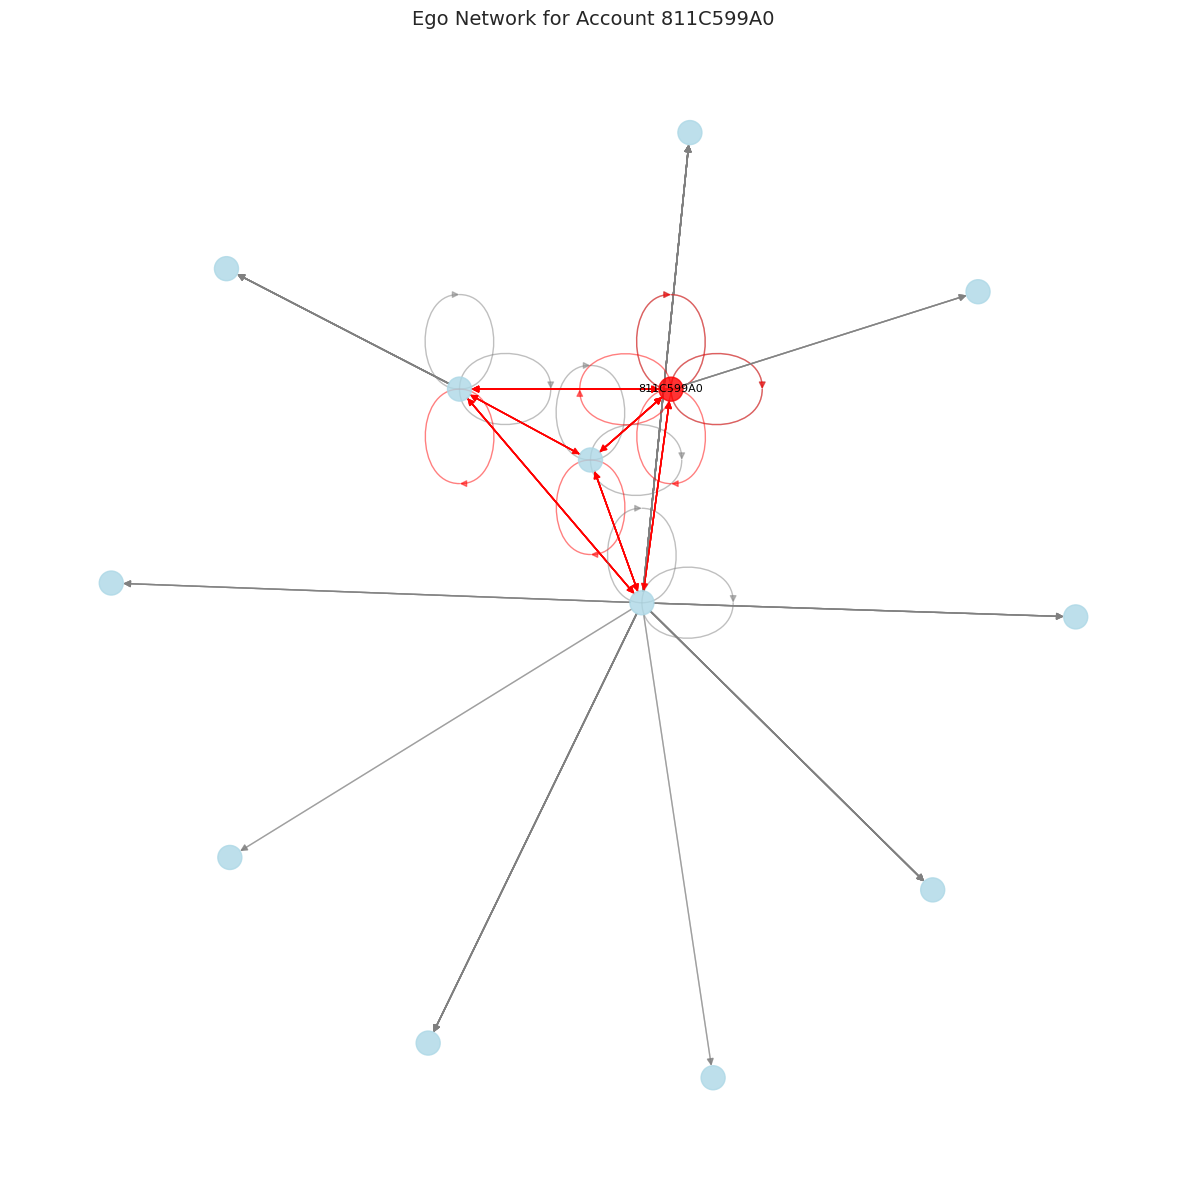

In [ ]:
pattern_types = patterns_df['pattern_type'].unique()

for ptype in pattern_types[:3]:
    examples = get_pattern_examples(patterns_df, ptype, num_examples=1)
    if len(examples) > 0:
        pattern_id = examples[0]
        
        center = get_pattern_center_node(patterns_df, pattern_id)
        
        radius = get_pattern_visualization_radius(patterns_df, pattern_id)
        
        print(f"Pattern {ptype} (ID {pattern_id}):")
        print(f"  Center node: {center}")
        
        if center in G_patterns:
            ego = extract_ego_network(G_patterns, center, radius=radius)
            fig = plot_ego_network(ego, center)
            plt.show()

#### Observations
- We can see clear patterns for FAN-OUT and SCATTER-GATHER. However, the example being loaded for CYCLE appears to be quite long and even with ego radius of 10, the cycle is not yet complete(edit: was a bug in code). This should suffice as a simple illustration of the patterns, though.
- If the graph doesn't look nice, run the above cell again. The nodes are kind of cramped together sometimes.

## 7. Temporal Dynamics

**Important Context**: This dataset has a front-loaded temporal distribution where 22% of transactions occur on Day 1 and 90% complete by Day 9. This is a characteristic of the AMLworld agent-based simulator. Therefore:
- Intraday patterns (hour-of-day analysis) remain valuable (?)
- Multi-day evolution has limited discriminative power
- Static graph analysis is recommended over temporal graph models

# Extract temporal features for intraday analysis

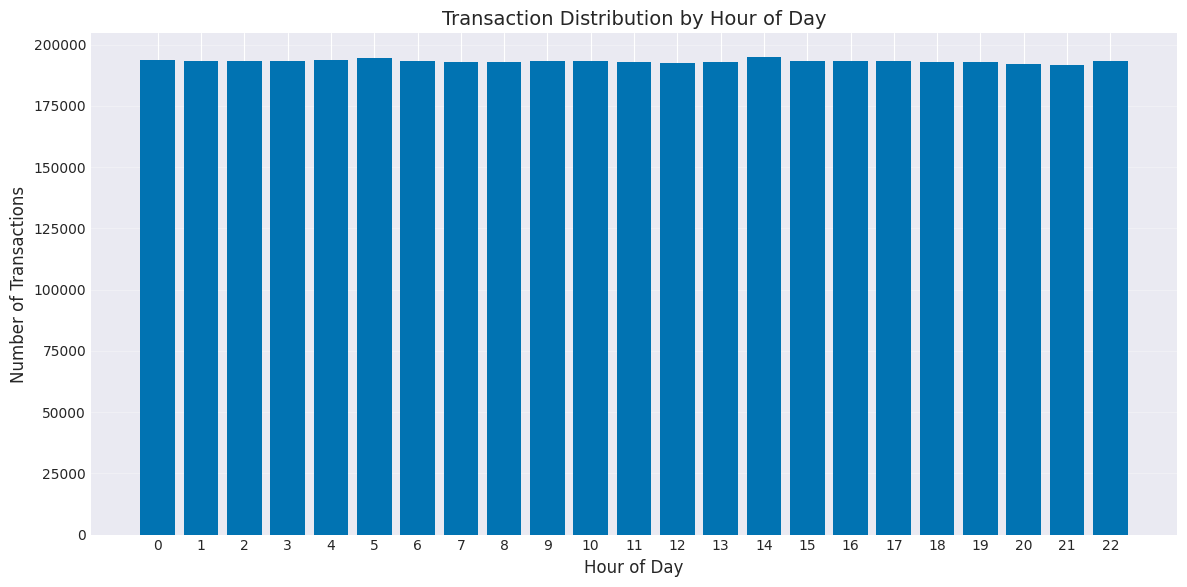

In [19]:
fig = plot_hourly_distribution(trans_df)
plt.show()

#### Observations
- This seems almost too neat, where every hour other than the first has almost the same number of transactions. I am not sure if this is by design to reflect real life transaction patterns or is another artifact of the data generation method.

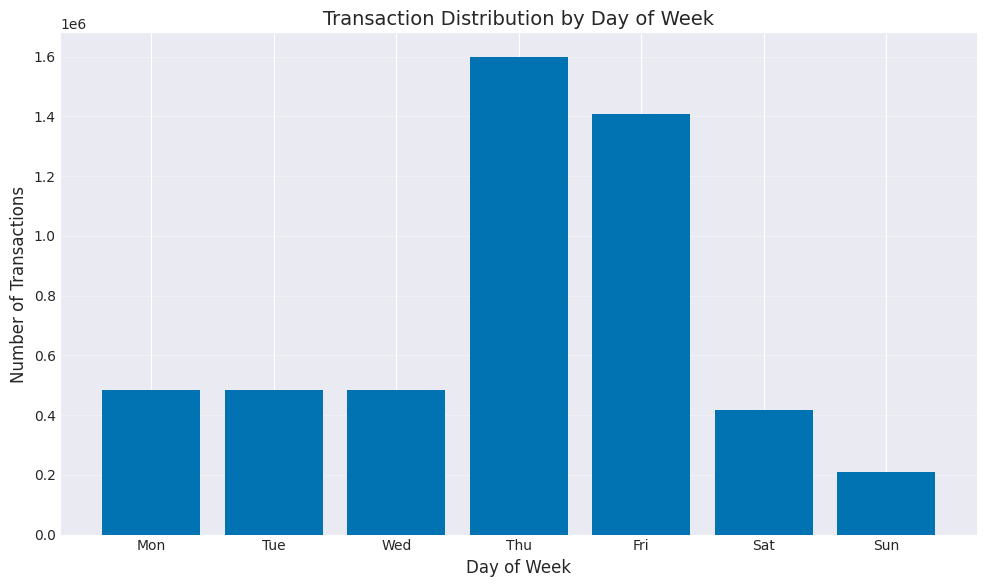

In [20]:
fig = plot_daily_distribution(trans_df)
plt.show()

#### Observation
- This is an example of why we should **NOT** use inter-day patterns or cyclical day-of-the-week encodings in our GNN. In real life data this would almost certanly not be the shape that we see. This is both a result of the temporal artifact discussed several times up to this point, and also the fact that this is effectively a 10-day dataset. Thus, there are 2 of some days of the week and only 1 of others in the data.